# Lab session 3 Instrumental Variables
The outline of this session is as follows:
1. recall omitted variable bias and its remedy
2. implement IV and 2SLS to address the confounding issue

## 1. Omitted Variable Bias and Imperfect Proxy

One way to control for OVB is, well, adding the omitted variable into our model. However, that is not always possible, mostly because we simply don't have data on the omitted variables. For instance, let's go back to our model for effect of education on wage:

$
\log(\mathrm{wage})_i = \beta_0 + \kappa \ \mathrm{educ}_i + \pmb{\beta}\mathrm{Ability}_i + u_i
$

To figure out the causal effect of education $\kappa$ on $\log\mathrm{(wage)}$ we need to control for ability factors $\mathrm{Ability}_i$. If we don't, we would likely have some bias, after all, ability is probably a confounder, causing both the treatment, education, and the outcome, earnings.

One way is to include ability in our linear regression model. However, we don't have good measurements of ability. The best we have are some very questionable proxies, like IQ. Adding the imperfect proxy variable IQ still cannot identify the causal effect of education on wages, as IQ may determine both the education level and wages.

In [27]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

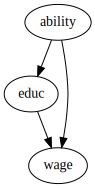

In [28]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

Here is where Instrumental Variables enters the picture. The idea of IV is to find another variable that causes the treatment and it is only correlated with the outcome through the treatment. Another way of saying this is that this instrument $Z_i$ is uncorrelated with the outcome $Y_0$, but it is correlated with the treatment $T$.

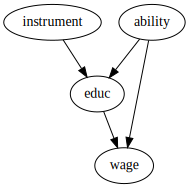

In [29]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

If we have such an instrument variable, we can recover the causal effect $\kappa$ with what we will see as the IV formula.

## Quarter of Birth and the Effect of Education on Wage

So far, we've been treating these instruments as some magical variable $Z$ which have the miraculous propriety of only affecting the outcome through the treatment. To be honest, good instruments are so hard to come by that we might as well consider them miracles. Let's just say it is not for the faint of heart. Rumor has it that the cool kids at Chicago School of Economics talk about how they come up with this or that instrument at the bar. 

![img](./data/img/iv/good-iv.png)

Still, we do have some interesting examples of instruments to make things a little more concrete. We will again try to estimate the effect of education on wage. To do so, we will use the person's quarter of birth as the instrument Z.

This idea takes advantage of US compulsory attendance law. Usually, they state that a kid must have turned 6 years by January 1 of the year they enter school. For this reason, kids that are born at the beginning of the year will enter school at an older age. Compulsory attendance law also requires students to be in school until they turn 16, at which point they are legally allowed to drop out. The result is that people born later in the year have, on average, more years of education than those born in the beginning of the year.

![img](./data/img/iv/qob.png)

If we accept that quarter of birth is independent of the ability factor, that is, it does not confound the impact of education on wage, we can use it as an instrument. In other words, we need to believe that quarter of birth has no impact on wage, other than through its impact on education. If you don't believe in astrology, this is a very compelling argument.

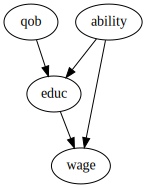

In [30]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

To perform this analysis, we can use data from three decennial census, the same data used by [Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991) in their article about IV. This dataset has information on log wages, our outcome variable, and years of schooling, our treatment variable. It also has data on quarter of birth, our instrument, and additional controls, such as year of birth and state of birth. 

In [31]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## The 1st Stage

Before we use quarter of birth as an instrument, we need to make sure it is a valid one. This implies arguing in favor of the two Instrumental Variables assumptions:

1. $\mathrm{Cov}(Z, T) \neq 0$. This is saying that we should have a strong 1st stage, or that the instrument indeed impacts the treatment variable.
2. $Y \perp Z | T $. This is the exclusion restriction, stating that the instrument Z only affects the outcome Y through the treatment T. 

The first assumption is fortunately verifiable. We can see from data that $\mathrm{Cov}(Z, T)$ is not zero. In our example, if quarter of birth is indeed an instrument like we've said, we should expect individuals born in the last quarter of the year to have slightly more time of education than those born in the beginning of the year. Before running any statistical test to verify this, let's just plot our data and see it with our own eyes.

In [32]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

In [33]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

,year_of_birth,quarter_of_birth,log_wage,years_of_schooling,time_of_birth
0,30.0,1.0,5.889133,12.280405,30.25
1,30.0,2.0,5.898007,12.428418,30.50
2,30.0,3.0,5.909365,12.491860,30.75
3,30.0,4.0,5.914354,12.624675,31.00
4,31.0,1.0,5.902136,12.540434,31.25


Remarkably, there is a seasonal pattern on the years of schooling that follows the quarter of the year. Visually, we can see that those born in the first quarter of the year have almost always less education than those born in the last quarter (once we control for the year of birth, after all, those born in later years have more education, in general).

To be a bit more rigorous, we can run the 1st stage as a linear regression. We will first convert the quarter of birth to dummy variables:

In [5]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


For simplicity, let's only use the last quarter, q4, as the instrument for now. We will run a regression of years of schooling, the treatment, on quarter of birth, the instrument. This will show us if indeed quarter of birth positively affects time of education like we saw in the plot above. We also need to control for years of birth here and we will add state of birth as an additional control.

In [9]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272786578
q4 p-value:,  5.4648294166163044e-15


It looks like those born in the last quarter of the year have, on average, 0.1 more years of education than those born in other quarters of the year. The p-value is close to zero. This closes the case on whether quarter of birth causes more or less years of schooling.

![img](./data/img/iv/incomplete-files.png)

## The Reduced Form

Unfortunately, we can't verify the second IV condition. We can only argue in favor of it. We can express our belief that quarter of birth does not influence potential earnings. In other words, the time people are born is not an indication of their personal ability or any other factor that can cause a difference in earnings, other than the effect on education. A good way of doing that is to say that the quarter of birth is as good as randomly assigned when we are thinking about it's impact on earnings. (It isn't random. There is evidence that people tend to conceive around the end of the summer or around some sort of holiday. But I can't think of any good reason that this pattern also affects income in any way other than through education).

Having argued in favor of the exclusion restriction, we can proceed to run the reduced form. The reduced form aims at figuring out how the instrument influences the outcome. Since, by assumption, all this influence is due to the effect on treatment, this will shed some light into how the treatment affects the outcome. Once again, let's evaluate this visually before getting serious with regression. 

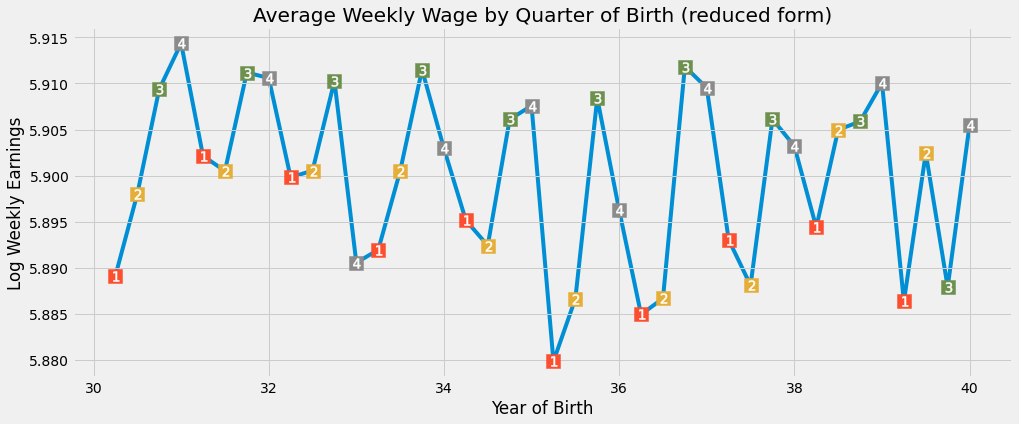

In [10]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

Once again, we can see a seasonal pattern on earnings by the quarter of birth. Those born later on the year have slightly higher income than those born in the beginning of the year. To test this hypothesis, we will again regress the instrumental q4 on log wage. We will also add the same additional controls as in the 1st stage:

In [11]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260140015
q4 p-value:,  0.0014949127183659584


Once again, we have a significant result. Those born in the last quarter of the year have, on average, 0.8% higher wages. This time, the p-value is not so close to zero as before, but it's still pretty significant, being just 0.0015. 

## Instrumental Variables by Hand

Having both our reduced form and our 1st stage, we can now scale the effect of the first stage by the reduced form. Since the first stage coefficient was something like 0.1, this will multiply the effect of the reduced form coefficient by almost 10. This will give us our unbiased IV estimate of the average causal effect:

$
\mathrm{ATE}_{IV} = \dfrac{\text{Reduced Form}}{\text{1st Stage}} 
$

In [12]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492085315

This means that we should expect each additional year of school to increase wages by 8%.

Another way to get the IV estimates is by using 2 stages least squares, **2SLS**. With this procedure, we do the first stage like before and then run a second stage where we replace the treatment variable by the fitted values of the 1st stage

$
\mathrm{educ}_i = \gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1\times \mathrm{educ}_i + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

$
\log(\mathrm{wage})_i = \beta_0 + \beta_1 [\gamma_0 + \gamma_1 \times \mathrm{q4}_i + \gamma_2\times \mathrm{yob}_i + \gamma_3\times \mathrm{sob}_i + v_i ]  + \beta_2\times \mathrm{yob}_i + \beta_3\times \mathrm{sob}_i + u_i
$

One thing to notice is that **any additional control we add to the second stage should also be added to the first stage when doing IV**. 

In [13]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.0853028649208674

As you can see, the parameters are exactly the same. This second way of looking at IV can be useful for the intuition it gives. In 2SLS, the first stage creates a new version of the treatment that is purged from omitted variable bias. We then use this purged version of the treatment, the fitted values of the 1st stage, in a linear regression.  

In practice, however, we don't do IV by hand. Not because it is troublesome, but because the standard errors we get from this second stage are a bit off. Instead, we should always let the machine do the job for us. In Python, we can use the library [linearmodels](https://bashtage.github.io/linearmodels/) to run 2SLS the right way.

The formula for 2SLS is a bit different. We should add the first stage between \[ \] inside the formula. In our case, we add `years_of_schooling ~ q4`. Additional controls don't need to be added to the first stage because the computer will do this automatically if we include them in the second stage. For this reason, we add `year_of_birth` and `state_of_birth` outside the formula of the 1st stage. 

In [14]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.0853028649580665
SE: 0.02554081280759766
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914592261452


Once again, we can see that the parameter is exactly the same as the ones we've got before. The extra benefit is that we have valid standard errors now. With this at hand, we can say that we expect 1 extra year of education to increase wages by 8.5%, on average. 

## Multiple Instruments

Another advantage of using the computers is to run 2SLS is that it is easy to add multiple instruments. In our example, we will use all quarter of birth dummies as instruments for years of schooling. 

In [15]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370488924324
SE: 0.0195571490089523
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


With all 3 dummies, the estimated return on education is now 0.1, which means that we should expect a 10% average increase on earnings for every additional year of education. Let's compare this with the traditional OLS estimate. To do that, we can use 2SLS again, but without the 1st stage now.

In [16]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.067325728176578
SE: 0.00038839984390487046
95 CI: [0.06656446 0.06808699]
P-value: 0.0


In [ ]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = smf.ols(formula, data=data).fit()
print(ols.summary())

In [ ]:
References:
Facure, Matheus, Causal Inference for The Brave and True. https://github.com/matheusfacure/python-causality-handbook